# Compute PCA within the 3L chrom - An. arabiensis

In [1]:
!pip install -q malariagen_data
!pip install -q scikit-allel
!pip install -q petl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.9/309.9 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 4.1 MB/s eta 0:00:00


### importing necessary package

In [2]:
import allel
import malariagen_data
import numpy as np
import pandas as pd
import dask
import dask.array as da
# silence some dask warnings
dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.diagnostics.progress import ProgressBar

In [3]:
import random
#import functools
#import petl as ptl
#import itertools
import scipy
from pathlib import Path
from collections import Counter

In [4]:
# plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib_venn as venn
import seaborn as sns

In [27]:
#Mounting Google Drive
import os
from google.colab import drive
drive.mount("drive")

# make dir 
results_dir = "drive/MyDrive/Genomic/"
os.makedirs(results_dir, exist_ok=True)

Mounted at drive


Importing malariagen data set    
Let's select the the sample set from 

In [5]:
ag3 = malariagen_data.Ag3("gs://vo_agam_release/", pre=True)
#ag3
sets = ["1191-VO-MULTI-OLOUGHLIN-VMF00106", "1191-VO-MULTI-OLOUGHLIN-VMF00140", 
             "AG1000G-BF-A", "AG1000G-BF-B", "AG1000G-BF-C"]
df_samples = ag3.sample_metadata(sample_sets=sets, sample_query='country == "Burkina Faso" and aim_species=="arabiensis"')#.set_index("sample_id")
#bf_samples = df_samples.query('country == "Burkina Faso" and year > 2004')
#bf_samples.groupby(['location', 'aim_species']).size()

#To access to the snp genotypes within the 3L chromosomes
chrom3L_gt = ag3.snp_calls(region="3L", sample_sets=sets, sample_query='country == "Burkina Faso" and aim_species=="arabiensis"')


Load sample metadata:   0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
# define population 
bf_samples = df_samples.query('country == "Burkina Faso" and year >2004')
s1, s2, pop_labels,pop_colors, = [], [], {}, {}
for iso, species in zip(bf_samples.location, bf_samples.aim_species):
    s1.append(iso[:4]+'_'+species[:3])
bf_samples.insert(4, 'population', s1)
###
s3=[]
for pop, year in zip(bf_samples.population, bf_samples.year):
    s3.append(pop+'_'+str(year))
bf_samples.insert(4, 'pop_year', s3)

##
#bf_samples_sel = pd.concat([bf_samples, bf_samples])
pop_ids = list(bf_samples.population.unique())
pop_ids1 = list(bf_samples.pop_year.unique())

#pop_id
for idx, species in zip(bf_samples.location, bf_samples.aim_species):
  w = idx.split(' ')[0][:14]
  s2.append(w+' $An.'+species)
val = list(Counter(s2).keys())
for idx, vl in zip(pop_ids, val):
    pop_labels[idx]=vl
pop_labels

#pop_labels & pop_colors
colored = sns.color_palette("husl", len(pop_ids))
for i in range(len(pop_ids)):
    pop_colors[pop_ids[i]] = colored[i]

pop_color = {'Bana_ara':'#FF6347', 'Pala_ara':'#FF00FF', 'Sour_ara':'#3D1C02'}
pop_color1 = {'Pala_ara_2014':'#FF6347', 'Pala_ara_2015':'#FF00FF', 'Pala_ara_2016':'#3D1C02'}

#pop_cohort
coh_pop = dict([(f"{p}", list(df.index)) for (p), df in bf_samples.reset_index().groupby(['population'])])
coh_pop1 = dict([(f"{p}", list(df.index)) for (p), df in bf_samples.reset_index().groupby(['pop_year'])])
#coh_pop.keys()
ls1 = pop_ids
ls2 = list(pop_color1.keys())
pop_idx, pop_idx1 = [], []
for pop in ls1:
  pop_idx = pop_idx + coh_pop[pop]
for pop in ls2:
  pop_idx1 = pop_idx1 +  coh_pop1[pop]
len(pop_idx), len(pop_idx1),

(115, 113)

In [7]:
for ids in coh_pop1:
  print(ids, len(coh_pop1[ids]))

Bana_ara_2014 1
Pala_ara_2014 11
Pala_ara_2015 88
Pala_ara_2016 14
Sour_ara_2017 1


In [9]:
#To the genomics dataset within the Target region and bf samples 
bf_snps = chrom3L_gt#.sel(samples=df_samples.eval('country=="Burkina Faso" and year > 2004'))

# Take some SNP in the 3L chromosomes 
bf_snps_pos = allel.SortedIndex(bf_snps['variant_position'].values)

# To filter the SNP dataset and warp the dataset to GT array 
filt = 'gamb_colu_arab' 
filt_val = bf_snps[f"variant_filter_pass_{filt}"].values 
gt_filtered = allel.GenotypeDaskArray(bf_snps["call_genotype"][filt_val].data)

# compute allele counts
with ProgressBar():
  ac = gt_filtered.take(pop_idx, axis=1).count_alleles(max_allele=3).compute()
  ac1 = gt_filtered.take(pop_idx1, axis=1).count_alleles(max_allele=3).compute()
#ac_pop = gt_filtered.count_alleles_subpops(coh_pop)

[########################################] | 100% Completed | 318.83 s
[########################################] | 100% Completed | 225.26 s


#PCA

In [10]:
#filter - to remove missing data
filter_ac = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
gt_rm_miss = gt_filtered.compress(filter_ac, axis=0)
geno_alt = gt_rm_miss.to_n_alt()

#filter - to remove missing data
filter_ac1 = (ac1.max_allele() == 1) & (ac1[:, :2].min(axis=1) > 1)
gt_rm_miss1 = gt_filtered.compress(filter_ac1, axis=0)
geno_alt1 = gt_rm_miss1.to_n_alt()

In [11]:
#randomly select snps 
n=300000   
rand_x = np.random.choice(geno_alt.shape[0], n, replace=False)
rand_x.sort()
gt_random = gt_rm_miss.take(rand_x, axis=0).to_n_alt()

#randomly select snps 
rand_x1 = np.random.choice(geno_alt1.shape[0], n, replace=False)
rand_x1.sort()
gt_random1 = gt_rm_miss1.take(rand_x1, axis=0).to_n_alt()

In [12]:
#define PCA path 
pca_data = Path('pca_data.npz')
pca_data

#define PCA path 
pca_data1 = Path('pca_data1.npz')
pca_data1

PosixPath('pca_data1.npz')

In [13]:
if pca_data.is_file():
    # file exist
    pca = np.load('pca_data.npz')
    coords = pca['coords']
    loadings = pca['loadings']
    variance = pca['variance']
else:
    print('processing')
    coords, model = allel.pca(gt_random, n_components=20, scaler='patterson')

processing


In [14]:
if pca_data1.is_file():
    # file exist
    pca = np.load('pca_data1.npz')
    coords = pca['coords']
    loadings = pca['loadings']
    variance = pca['variance']
else:
    print('processing')
    coords1, model1 = allel.pca(gt_random1, n_components=20, scaler='patterson')

processing


In [29]:
## save PCA data 
np.save('drive/MyDrive/Genomic/PCA/3L_coords_ara', coords)
np.save('drive/MyDrive/Genomic/PCA/3L_model_ara', model)

def load_coords(file='coords.npy'):
  return np.load(f'drive/MyDrive/Genomic/PCA/{file}')

def load_model(file='model.npy'):
  return np.load(f'drive/MyDrive/Genomic/PCA/{file}', allow_pickle='TRUE').item()

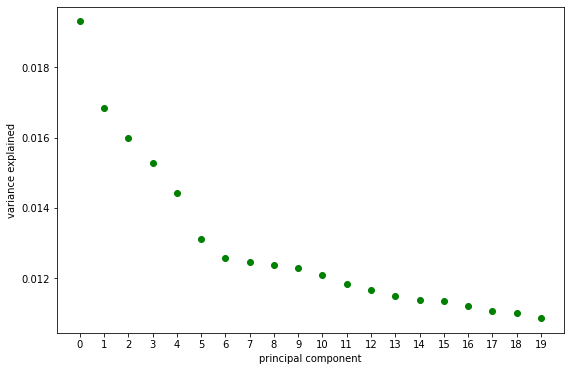

In [15]:
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(121)
if 'variance' in globals():
    ax.plot(variance, 'go')
else:
    ax.plot(model.explained_variance_ratio_, 'go')
ax.set_xlabel("principal component")
ax.set_ylabel("variance explained")
plt.xticks(np.arange(0,20, 1));

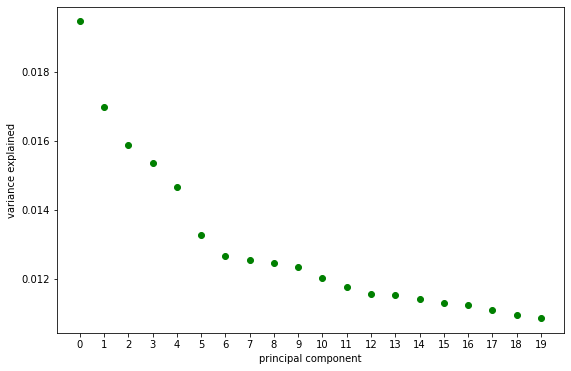

In [16]:
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(121)
if 'variance' in globals():
    ax.plot(variance, 'go')
else:
    ax.plot(model1.explained_variance_ratio_, 'go')
ax.set_xlabel("principal component")
ax.set_ylabel("variance explained")
plt.xticks(np.arange(0,20, 1));

In [30]:
def marker_style (pop_ids):
  marker = {}
  for pop in pop_ids:
    if pop.split('_')[0]=='Pala':
      marker[pop] = 'o'
    elif pop.split('_')[0]=='Bana':
      marker[pop] = 'D'
    elif pop.split('_')[0]=='Sour':
      marker[pop] = 'v'
    elif pop.split('_')[1]=='int':
      marker[pop] = '*'
    else:
      marker[pop] = 'h'
  return marker

def marker_style1 (pop_ids1):
  marker = {}
  for pop in pop_ids1:
    if pop.split('_')[0]=='Pala':
      marker[pop] = 'o'
    elif pop.split('_')[0]=='Bana':
      marker[pop] = 'D'
    elif pop.split('_')[0]=='Sour':
      marker[pop] = 'v'
    elif pop.split('_')[1]=='int':
      marker[pop] = '*'
    else:
      marker[pop] = 'h'
  return marker

In [19]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in ls1:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker=marker_style(pop_ids)[pop], linestyle=' ', color=pop_color[pop], 
                label=pop, markersize=6, mec='k', mew=0.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model[pc2]*100))

def plot_pca_coords1(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in ls2:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker=marker_style1(pop_ids1)[pop], linestyle=' ', color=pop_color1[pop], 
                label=pop, markersize=6, mec='k', mew=0.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model[pc2]*100))

In [20]:
def fig_pca(coords, model, title, sample_population, fig_name=None):
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(231)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)

    ax = fig.add_subplot(232)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    
    ax = fig.add_subplot(233)
    plot_pca_coords(coords, model, 4, 5, ax, sample_population)
    
    ax = fig.add_subplot(234)
    plot_pca_coords(coords, model, 6, 7, ax, sample_population)
    
    ax = fig.add_subplot(235)
    plot_pca_coords(coords, model, 8, 9, ax, sample_population)
    
    ax = fig.add_subplot(236)
    plot_pca_coords(coords, model, 10, 11, ax, sample_population)

    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    
    fig.suptitle(title, y=1.02)
    fig.tight_layout()
    
    if fig_name:
      fig.savefig(f"drive/MyDrive/Genomic/PCA/{fig_name}.png", dpi=300, bbox_inches='tight')

def fig_pca1(coords, model, title, sample_population, fig_name=None):
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(231)
    plot_pca_coords1(coords, model, 0, 1, ax, sample_population)

    ax = fig.add_subplot(232)
    plot_pca_coords1(coords, model, 2, 3, ax, sample_population)
    
    ax = fig.add_subplot(233)
    plot_pca_coords1(coords, model, 4, 5, ax, sample_population)
    
    ax = fig.add_subplot(234)
    plot_pca_coords1(coords, model, 6, 7, ax, sample_population)
    
    ax = fig.add_subplot(235)
    plot_pca_coords1(coords, model, 8, 9, ax, sample_population)
    
    ax = fig.add_subplot(236)
    plot_pca_coords1(coords, model, 10, 11, ax, sample_population)

    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    
    fig.suptitle(title, y=1.02)
    fig.tight_layout()
    
    if fig_name:
      fig.savefig(f"drive/MyDrive/Genomic/PCA/{fig_name}.png", dpi=300, bbox_inches='tight')


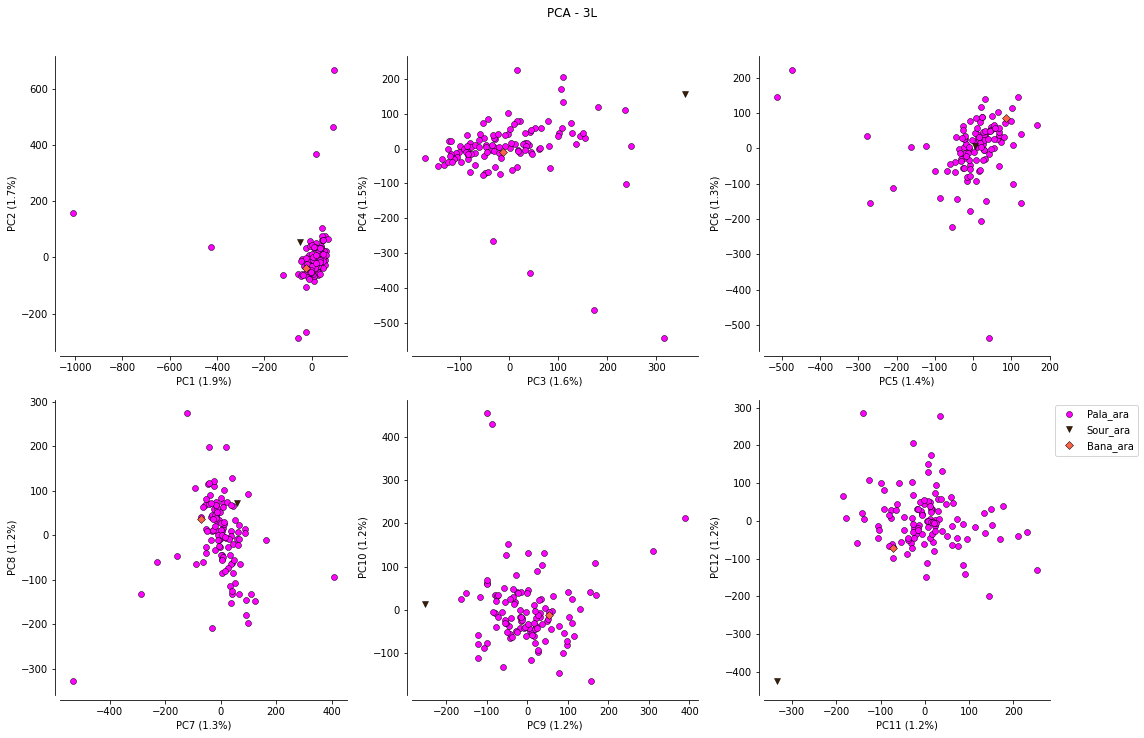

In [21]:
if 'variance' in globals():
    fig_pca(coords, variance ,'PCA - 3L', bf_samples.population.values)
else:
    fig_pca(coords, model.explained_variance_ratio_ ,'PCA - 3L', bf_samples.population.values)

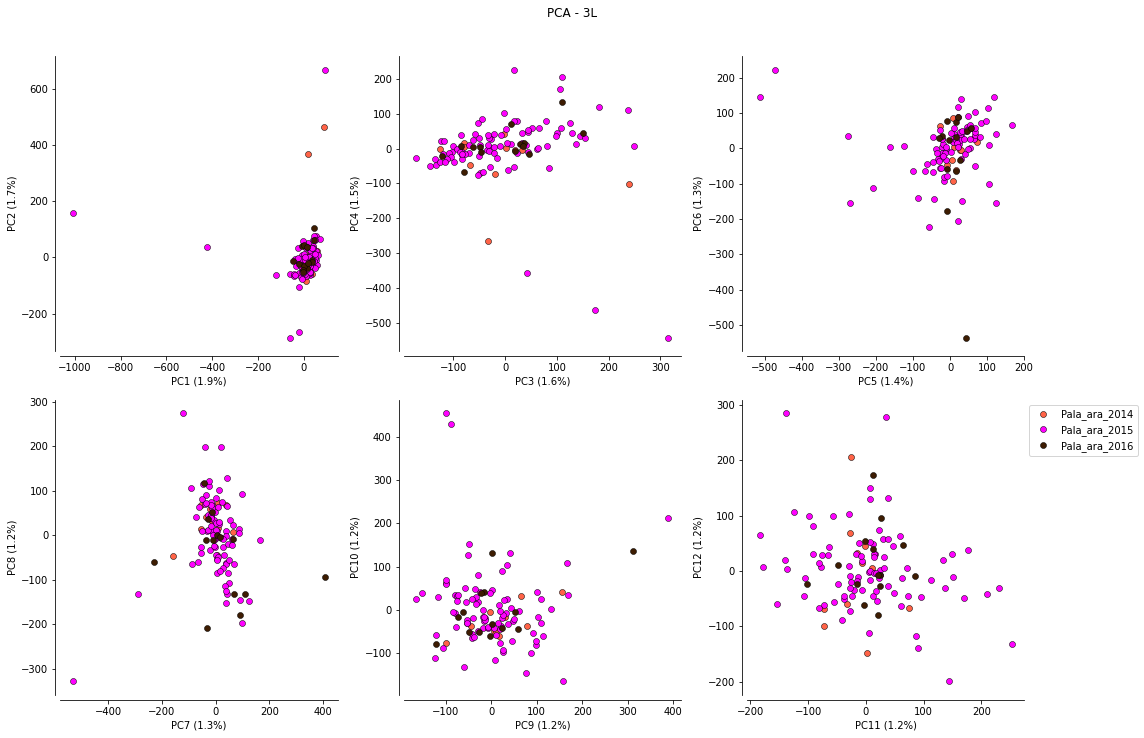

In [22]:
if 'variance' in globals():
    fig_pca1(coords, variance ,'PCA - 3L', bf_samples.pop_year.values)
else:
    fig_pca1(coords, model.explained_variance_ratio_ ,'PCA - 3L', bf_samples.pop_year.values)

In [23]:
def fig_pca1_2(coords, model, title, sample_population, fig_name=None):
    # plot coords for PCs 1 vs 2
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot()
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)

    ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
    
    fig.suptitle(title, y=1.02)
    fig.tight_layout()

    if fig_name:
      fig.savefig(f"drive/MyDrive/Genomic/PCA/{fig_name}.png", dpi=300, bbox_inches='tight')

def fig_pca1_2_1(coords, model, title, sample_population, fig_name=None):
    # plot coords for PCs 1 vs 2
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot()
    plot_pca_coords1(coords, model, 0, 1, ax, sample_population)

    ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
    
    fig.suptitle(title, y=1.02)
    fig.tight_layout()

    if fig_name:
      fig.savefig(f"drive/MyDrive/Genomic/PCA/{fig_name}.png", dpi=300, bbox_inches='tight')


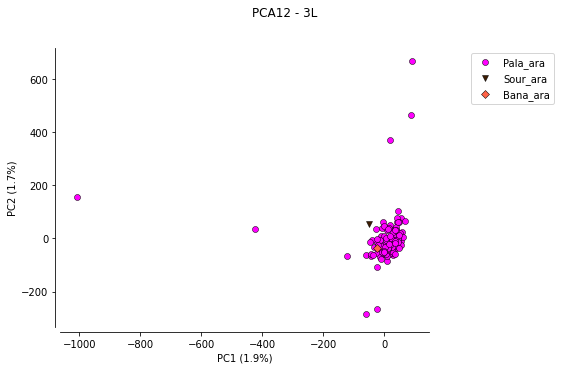

In [24]:
if 'variance' in globals():
    fig_pca1_2(coords, variance ,'PCA12 - 3L', bf_samples.population.values)
else:
    fig_pca1_2(coords, model.explained_variance_ratio_ ,'PCA12 - 3L', bf_samples.population.values)

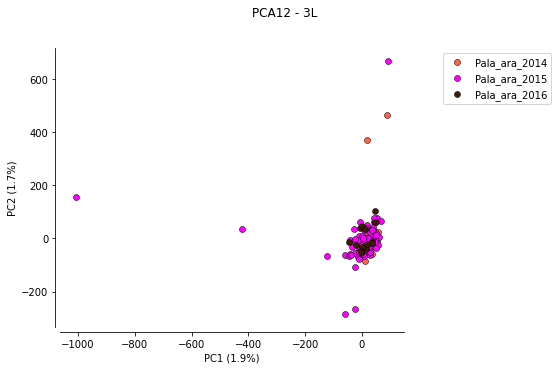

In [26]:
if 'variance' in globals():
    fig_pca1_2_1(coords, variance ,'PCA12 - 3L', bf_samples.pop_year.values)
else:
    fig_pca1_2_1(coords, model.explained_variance_ratio_ ,'PCA12 - 3L', bf_samples.pop_year.values)